In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re

In [2]:
file_path = "C:\עידו\אוניברסיטת אריאל\שנה ג\סמסטר ב\כרייה וניתוח נתונים מתקדם בפייתון\מטלה 2\matala2_cosmetics_2019-Nov.csv"
data = pd.read_csv(file_path, low_memory=False)

### Q1

In [3]:
def get_time_diff(data):
    if data.user_session == data.next_event_user_session:
        time_diff = (data['next_event_time'] - data['event_time']).total_seconds()
    else:
        time_diff = 0
    return time_diff

In [4]:
data.event_time = pd.to_datetime(data.event_time)
data = data.sort_values(by= ['user_session', 'event_time'], ascending = True)
data['next_event_time'] = data.event_time.shift(-1)
data['next_event_user_session'] = data.user_session.shift(-1)
data['duration_to_next_event'] = data.apply(get_time_diff, axis=1)
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,next_event_time,next_event_user_session,duration_to_next_event
522763,2019-11-05 07:57:05,view,5829298,1487580011585070000,NaN,farmstay,0.79,556321594,00000dd2-0f5d-4fc9-9d6b-2fc8c7514b04,2019-11-03 12:45:44,00005ac0-5c22-4756-bb12-31b90af75fa3,0.0
284392,2019-11-03 12:45:44,view,5846437,1487580013950660000,NaN,browxenna,45.24,473600495,00005ac0-5c22-4756-bb12-31b90af75fa3,2019-11-03 12:45:55,00005ac0-5c22-4756-bb12-31b90af75fa3,11.0
284416,2019-11-03 12:45:55,view,5846436,1487580013950660000,NaN,browxenna,45.24,473600495,00005ac0-5c22-4756-bb12-31b90af75fa3,2019-11-02 09:13:51,0000d358-49a1-4a54-b402-08205c35981c,0.0
144335,2019-11-02 09:13:51,view,5887753,1487580013279570000,NaN,NaN,3.56,557616099,0000d358-49a1-4a54-b402-08205c35981c,2019-11-07 11:18:15,0000d72e-be5f-4a03-9f17-6ac81584f177,0.0
853411,2019-11-07 11:18:15,view,59996,1487580012927250000,NaN,NaN,4.13,463202709,0000d72e-be5f-4a03-9f17-6ac81584f177,2019-11-07 11:19:26,0000d72e-be5f-4a03-9f17-6ac81584f177,71.0


### Q2

In [5]:
data = data.sort_values(by=['user_id','event_time'])
data['event_date'] = data['event_time'].dt.date 

In [6]:
data['days_between'] = (data.groupby('user_id')['event_date']
                                        .diff().apply(pd.Timedelta).dt.days
                                        .fillna(0))
data.iloc[data[data['user_id'] != data['user_id'].shift()].index, -2] = None

In [7]:
data['funnel_number'] = (data.groupby('user_id')['days_between']
                                       .transform(lambda x: (x.cumsum() // 5) + 1))
data['funnel_number'] = data['funnel_number'].fillna(1)

In [8]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,next_event_time,next_event_user_session,duration_to_next_event,event_date,days_between,funnel_number
437209,2019-11-04 15:28:57,view,5240,1487580009202710000,NaN,runail,4.05,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,2019-11-07 11:10:56,d04876f6-c9dc-4225-bec1-76d2d60fcc75,0.0,None,0.0,1.0
697519,2019-11-06 10:40:34,cart,5614842,1487580005411060000,NaN,cnd,13.56,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-06 10:41:26,f873d16b-4efa-4e92-81be-92948aef2ff5,52.0,None,0.0,1.0
697645,2019-11-06 10:41:26,cart,5766379,1783999067156640000,NaN,kaaral,12.25,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-06 10:43:30,f873d16b-4efa-4e92-81be-92948aef2ff5,124.0,None,0.0,1.0
698043,2019-11-06 10:43:30,purchase,5766379,1783999067156640000,NaN,kaaral,12.25,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-06 10:43:30,f873d16b-4efa-4e92-81be-92948aef2ff5,0.0,None,0.0,1.0
698045,2019-11-06 10:43:30,purchase,5614842,1487580005411060000,NaN,cnd,13.56,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-02 13:54:10,f873f8ae-54c7-4ca9-9d76-bc5c03154e72,0.0,2019-11-06,0.0,1.0


### Q3

In [9]:
data['index_in_funnel'] = data.groupby(['user_id', 'funnel_number']).cumcount()+1
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,next_event_time,next_event_user_session,duration_to_next_event,event_date,days_between,funnel_number,index_in_funnel
437209,2019-11-04 15:28:57,view,5240,1487580009202710000,NaN,runail,4.05,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,2019-11-07 11:10:56,d04876f6-c9dc-4225-bec1-76d2d60fcc75,0.0,None,0.0,1.0,1
697519,2019-11-06 10:40:34,cart,5614842,1487580005411060000,NaN,cnd,13.56,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-06 10:41:26,f873d16b-4efa-4e92-81be-92948aef2ff5,52.0,None,0.0,1.0,1
697645,2019-11-06 10:41:26,cart,5766379,1783999067156640000,NaN,kaaral,12.25,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-06 10:43:30,f873d16b-4efa-4e92-81be-92948aef2ff5,124.0,None,0.0,1.0,2
698043,2019-11-06 10:43:30,purchase,5766379,1783999067156640000,NaN,kaaral,12.25,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-06 10:43:30,f873d16b-4efa-4e92-81be-92948aef2ff5,0.0,None,0.0,1.0,3
698045,2019-11-06 10:43:30,purchase,5614842,1487580005411060000,NaN,cnd,13.56,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-02 13:54:10,f873f8ae-54c7-4ca9-9d76-bc5c03154e72,0.0,2019-11-06,0.0,1.0,4


### Q4

In [10]:
data['price'] = data.price.apply(lambda x: "".join(re.findall('[.,0-9]', x))).astype(float)
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,next_event_time,next_event_user_session,duration_to_next_event,event_date,days_between,funnel_number,index_in_funnel
437209,2019-11-04 15:28:57,view,5240,1487580009202710000,NaN,runail,4.05,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,2019-11-07 11:10:56,d04876f6-c9dc-4225-bec1-76d2d60fcc75,0.0,None,0.0,1.0,1
697519,2019-11-06 10:40:34,cart,5614842,1487580005411060000,NaN,cnd,13.56,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-06 10:41:26,f873d16b-4efa-4e92-81be-92948aef2ff5,52.0,None,0.0,1.0,1
697645,2019-11-06 10:41:26,cart,5766379,1783999067156640000,NaN,kaaral,12.25,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-06 10:43:30,f873d16b-4efa-4e92-81be-92948aef2ff5,124.0,None,0.0,1.0,2
698043,2019-11-06 10:43:30,purchase,5766379,1783999067156640000,NaN,kaaral,12.25,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-06 10:43:30,f873d16b-4efa-4e92-81be-92948aef2ff5,0.0,None,0.0,1.0,3
698045,2019-11-06 10:43:30,purchase,5614842,1487580005411060000,NaN,cnd,13.56,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,2019-11-02 13:54:10,f873f8ae-54c7-4ca9-9d76-bc5c03154e72,0.0,2019-11-06,0.0,1.0,4


### Q5

Kinds of events: ['view' 'cart' 'purchase' 'remove_from_cart']


<AxesSubplot:>

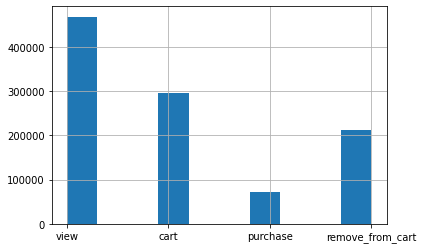

In [11]:
print(f"Kinds of events: {data.event_type.unique()}")
data.event_type.hist()

### Q6

In [12]:
grouped = data.groupby(['user_id', 'user_session', 'funnel_number'])
session_data = pd.DataFrame()

In [13]:
session_data['user_id'] = grouped['user_id'].first()
session_data['user_session'] = grouped['user_session'].first()
session_data['funnel_number'] = grouped['funnel_number'].first()
session_data['index_in_funnel'] = grouped['index_in_funnel'].apply(list)

In [14]:
session_data['total_events'] = data.groupby(['user_id', 'user_session'])['user_session'].count()
session_data['seconds_between'] = data.groupby(['user_id','user_session'])['duration_to_next_event'].sum()

In [15]:
view_sort = data[data['event_type'] == 'view']
session_data['list_of_viewed'] = view_sort.groupby(['user_id', 'user_session'])['product_id'].apply(list)

In [16]:
cart_sort = data[data['event_type'] == 'cart']
session_data['list_of_added_to_cart'] = cart_sort.groupby(['user_id', 'user_session'])['product_id'].apply(list)

In [17]:
purchase_sort = data[data['event_type'] == 'purchase']
session_data['list_of_purchased '] = cart_sort.groupby(['user_id', 'user_session'])['product_id'].apply(list)

In [18]:
session_data.head(8)

user_id  \
user_id  user_session                         funnel_number             
1120748  d0484d94-7ac1-44e8-a310-2360da11ad9d 1.0             1120748   
10079204 f873d16b-4efa-4e92-81be-92948aef2ff5 1.0            10079204   
10521214 25d2d492-d688-4baa-adf1-7296dbdd663e 1.0            10521214   
11274156 0c778a88-4700-4e8b-becb-3371ec28ea79 1.0            11274156   
         7bcf0afd-33ab-49ca-bd55-9c11a817b3d2 1.0            11274156   
13117447 1a345ef5-9a1e-47b3-b242-2cbb6b31d573 1.0            13117447   
14297993 a3bcb3c1-d3a3-49e5-b99b-7428f553a59b 1.0            14297993   
15400971 33bfc3f7-32a5-408d-aa1c-d8a681977aef 1.0            15400971   

                                                                                     user_session  \
user_id  user_session                         funnel_number                                         
1120748  d0484d94-7ac1-44e8-a310-2360da11ad9d 1.0            d0484d94-7ac1-44e8-a310-2360da11ad9d   
10079204 f873d16b-4efa-4e92-81be-92948aef2ff5 1.0            f873d16b-4efa-4e92-81be-92948aef2ff5   
10521214 25d2d492-d688-4baa-adf1-7296dbdd663e 1.0            25d2d492-d688-4baa-adf1-7296dbdd663e   
11274156 0c778a88-4700-4e8b-becb-3371ec28ea79 1.0            0c778a88-4700-4e8b-becb-3371ec28ea79   
         7bcf0afd-33ab-49ca-bd55-9c11a817b3d2 1.0            7bcf0afd-33ab-49ca-bd55-9c11a817b3d2   
13117447 1a345ef5-9a1e-47b3-b242-2cbb6b31d573 1.0            1a345ef5-9a1e-47b3-b242-2cbb6b31d573   
14297993 a3bcb3c1-d3a3-49e5-b99b-7428f553a59b 1.0            a3bcb3c1-d3a3-49e5-b99b-7428f553a59b   
15400971 33bfc3f7-32a5-408d-aa1c-d8a681977aef 1.0            33bfc3f7-32a5-408d-aa1c-d8a681977aef   

                                                             funnel_number  \
user_id  user_session                         funnel_number                  
1120748  d0484d94-7ac1-44e8-a310-2360da11ad9d 1.0                      1.0   
10079204 f873d16b-4efa-4e92-81be-92948aef2ff5 1.0                      1.0   
10521214 25d2d492-d688-4baa-adf1-7296dbdd663e 1.0                      1.0   
11274156 0c778a88-4700-4e8b-becb-3371ec28ea79 1.0                      1.0   
         7bcf0afd-33ab-49ca-bd55-9c11a817b3d2 1.0                      1.0   
13117447 1a345ef5-9a1e-47b3-b242-2cbb6b31d573 1.0                      1.0   
14297993 a3bcb3c1-d3a3-49e5-b99b-7428f553a59b 1.0                      1.0   
15400971 33bfc3f7-32a5-408d-aa1c-d8a681977aef 1.0                      1.0   

                                                                   index_in_funnel  \
user_id  user_session                         funnel_number                          
1120748  d0484d94-7ac1-44e8-a310-2360da11ad9d 1.0                              [1]   
10079204 f873d16b-4efa-4e92-81be-92948aef2ff5 1.0                     [1, 2, 3, 4]   
10521214 25d2d492-d688-4baa-adf1-7296dbdd663e 1.0                        [1, 2, 3]   
11274156 0c778a88-4700-4e8b-becb-3371ec28ea79 1.0                           [1, 2]   
         7bcf0afd-33ab-49ca-bd55-9c11a817b3d2 1.0                              [3]   
13117447 1a345ef5-9a1e-47b3-b242-2cbb6b31d573 1.0            [1, 2, 3, 4, 5, 6, 7]   
14297993 a3bcb3c1-d3a3-49e5-b99b-7428f553a59b 1.0                           [1, 2]   
15400971 33bfc3f7-32a5-408d-aa1c-d8a681977aef 1.0               [1, 2, 3, 4, 5, 6]   

                                                             total_events  \
user_id  user_session                         funnel_number                 
1120748  d0484d94-7ac1-44e8-a310-2360da11ad9d 1.0                       1   
10079204 f873d16b-4efa-4e92-81be-92948aef2ff5 1.0                       4   
10521214 25d2d492-d688-4baa-adf1-7296dbdd663e 1.0                       3   
11274156 0c778a88-4700-4e8b-becb-3371ec28ea79 1.0                       2   
         7bcf0afd-33ab-49ca-bd55-9c11a817b3d2 1.0                       1   
13117447 1a345ef5-9a1e-47b3-b242-2cbb6b31d573 1.0                       7   
14297993 a3bcb3c1-d3a3-49e5-b99b-7428f553a59b 1.0             